In [31]:
import rfpimp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.experimental import enable_iterative_imputer
from sklearn import ensemble, impute, model_selection, preprocessing, tree, linear_model, feature_selection
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import RFECV

In [2]:
def tweak_titanic(df):
    return df.drop(['name', 'ticket', 'home.dest', 'boat', 'body', 'cabin'], axis=1) \
             .pipe(pd.get_dummies, drop_first=True)

def get_train_test_X_y(df, y_col, test_size=0.3, std_cols=None):
    y = df[y_col]
    x = df.drop(y_col, axis=1)

    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare"]

    X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=test_size, random_state=42)
    fi = impute.IterativeImputer()

    X_train.loc[:, num_cols]=fi.fit_transform(X_train[num_cols])
    X_test.loc[:, num_cols] = fi.transform(X_test[num_cols])

    if std_cols:
        std = preprocessing.StandardScaler()
        X_train.loc[:, std_cols] = std.fit_transform(X_train[std_cols])
        X_test.loc[:, std_cols] = std.transform(X_test[std_cols])

    return X_train, X_test, y_train, y_test

In [3]:
df = pd.read_csv('titanic3.csv')
orig_df = df

agg = df.groupby("cabin") \
        .agg("min,max,mean,sum".split(",")) \
        .reset_index()

agg.columns = ["_".join(c).strip("_") for c in agg.columns.values]
agg_df = df.merge(agg, on="cabin")

ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1737: Setti

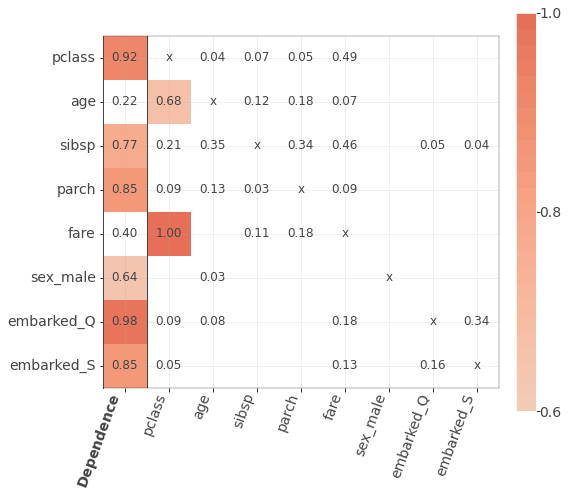

In [4]:
# Multicolinearity Plot
rfpimp.plot_dependence_heatmap(
    rfpimp.feature_dependence_matrix(X_train),
    value_fontsize=12,
    label_fontsize=14,
    figsize=(8, 8)
)
fig = plt.gcf()

In [8]:
# Show that removing colinear features, doesn't change the models outcome too much
cols_to_remove = [
    "fare",
    "age"
]
rf3 = RandomForestClassifier(random_state=42)
rf3.fit(
    X_train[
        [
            c
            for c in X_train.columns
            if c not in cols_to_remove
        ]
    ],
    y_train,
)
print (rf3.score(
    X_test[
        [
            c
            for c in X_train.columns
            if c not in cols_to_remove
        ]
    ],
    y_test,
))
rf4 = RandomForestClassifier(random_state=42)
rf4.fit(X_train, y_train)
rf4.score(X_test, y_test)

0.7913486005089059


0.7938931297709924

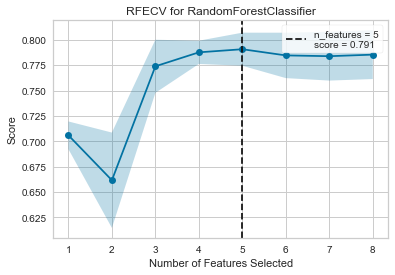

<AxesSubplot:title={'center':'RFECV for RandomForestClassifier'}, xlabel='Number of Features Selected', ylabel='Score'>

In [27]:
# Recursive feature estimation
fig, ax = plt.subplots(figsize=(6, 4))
rfe = RFECV(
    ensemble.RandomForestClassifier(
        n_estimators=100
    ),
    cv=5,
)
rfe.fit(X, y)
rfe.rfe_estimator_.ranking_
rfe.rfe_estimator_.n_features_
rfe.rfe_estimator_.support_
rfe.poof()

In [30]:
model = ensemble.RandomForestClassifier(
    n_estimators=100
)
rfe = feature_selection.RFE(model, 4)
rfe.fit(X, y)
X.columns[rfe.support_]

C:\Users\daniel.brooks\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Index(['pclass', 'age', 'fare', 'sex_male'], dtype='object')

<AxesSubplot:ylabel='feature'>

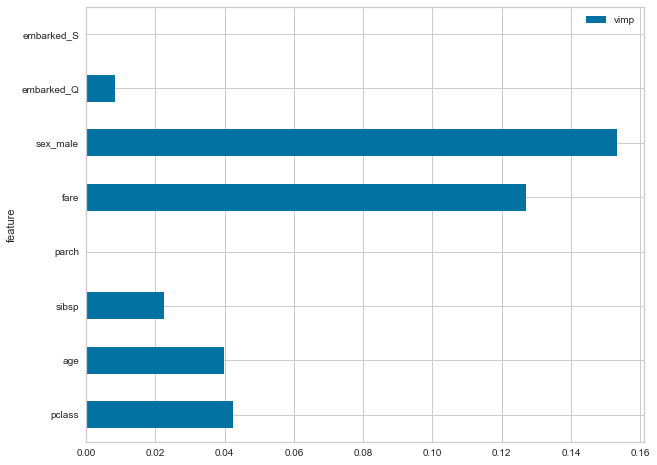

In [32]:
# Mutual Information
mic = feature_selection.mutual_info_classif(
    X, y
)
fig, ax = plt.subplots(figsize=(10, 8))
(
    pd.DataFrame(
        {"feature": X.columns, "vimp": mic}
    )
    .set_index("feature")
    .plot.barh(ax=ax)
)